In [27]:
!pip install keras
!pip install pydot
!pip install graphviz 
!apt-get install graphviz
! pip install git+https://www.github.com/keras-team/keras-contrib.git

from keras_contrib.applications.densenet import __create_dense_net
from PIL import Image
from matplotlib.pyplot import imshow

from IPython.display import Image
%matplotlib inline
def warn(*args, **kwargs):
    pass
import warnings
import numpy as np
warnings.warn = warn
import keras
from keras.utils import np_utils
from keras.layers.merge import concatenate
from keras.utils.vis_utils import plot_model
from keras.regularizers import l2
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-_880mbbx
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-_880mbbx
  Stored in directory: /tmp/pip-ephem-wheel-cache-z1cv6cuf/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
def DenseNet(input_shape=None,
             depth=40,
             nb_dense_block=3,
             growth_rate=12,
             nb_filter=-1,
             nb_layers_per_block=-1,
             bottleneck=False,
             dropout_rate=0.0,
             weight_decay=1e-4,
             subsample_initial_block=False,
             include_top=True,
             weights=None,
             input_tensor=None,
             pooling=None,
             classes=10,
             reduction=0.0,
             activation='softmax',
             transition_pooling='avg'):
    
    assert activation in ['softmax']
    
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=32,
                                      min_size=8,
                                      data_format=k.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not k.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = __create_dense_net(classes, img_input, include_top, depth, nb_dense_block,
                           growth_rate, nb_filter, nb_layers_per_block, bottleneck,
                           reduction, dropout_rate, weight_decay, subsample_initial_block,
                           pooling, activation, transition_pooling)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(10, activation='softmax')(x)
    
    inputs = img_input
    # Create model.
    model = Model(inputs, x, name='densenet')

    
    return model

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 70
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.0
lr = .4
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.
# convert to one hot encoing 
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=5. / 32,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=5. / 32,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train, seed=0, augment=False, rounds=1)


In [31]:
depth = 46
nb_dense_block = 3
growth_rate = 12
nb_filter = 15
dropout_rate = 0

model = DenseNet(depth=depth, nb_dense_block=nb_dense_block,
                 growth_rate=growth_rate, nb_filter=nb_filter,
                 dropout_rate=dropout_rate, bottleneck=False,
                 input_shape=(32,32,3), weights=None,
                 reduction=.4)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Image('model_plot.png')

model.summary()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', factor=0.01,
                          cooldown=0, patience=8, min_lr=0.5e-6, verbose=1)
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('weights.{epoch:02d}.hdf5', save_best_only=False, monitor='val_loss', mode='min')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
initial_conv2D (Conv2D)         (None, 32, 32, 15)   405         input_2[0][0]                    
__________________________________________________________________________________________________
dense_0_0_bn (BatchNormalizatio (None, 32, 32, 15)   60          initial_conv2D[0][0]             
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 32, 32, 15)   0           dense_0_0_bn[0][0]               
__________________________________________________________________________________________________
dense_0_0_

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=lr),
              metrics=['accuracy'])


In [33]:
!ls

model_plot.png	sample_data  weights.06.hdf5


In [0]:
from google.colab import files
# files.upload()

In [35]:
model.load_weights(filepath='weights.06.hdf5')
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 8s 834us/step
Test loss: 0.3498307225942612
Test accuracy: 0.9103


In [0]:
start, end = 0, 64
preds = []
index = []
while len(preds) < 50:
    
    temp = model.predict(x_test[start:end])
    for i, j, k in zip(temp, y_test[start: end], x_test[start:end]):
        if np.argmax(j) != np.argmax(i):
            preds.append(i)
            index.append(k)
    start += 64
    end += 64
    

In [0]:
class_idx = [np.argmax(i) for i in preds]
# print(y_test[0], class_idx)
class_output = [model.output[:, i] for i in class_idx]

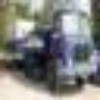

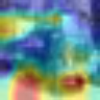

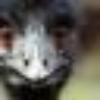

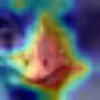

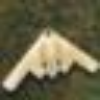

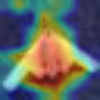

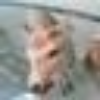

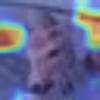

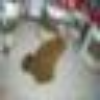

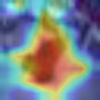

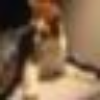

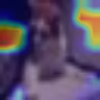

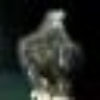

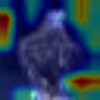

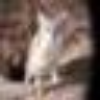

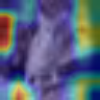

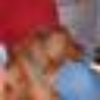

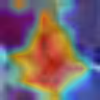

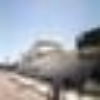

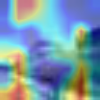

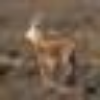

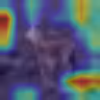

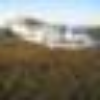

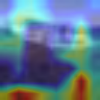

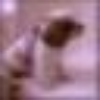

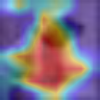

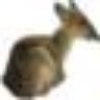

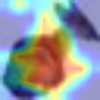

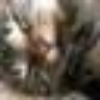

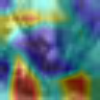

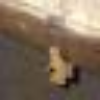

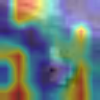

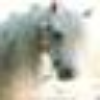

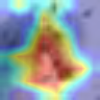

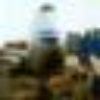

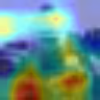

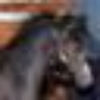

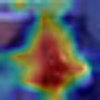

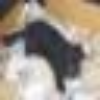

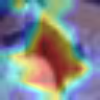

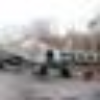

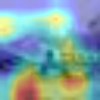

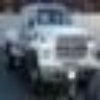

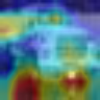

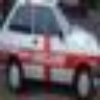

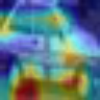

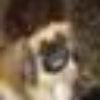

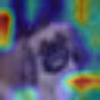

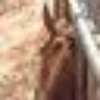

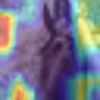

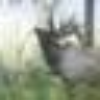

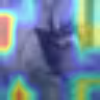

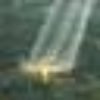

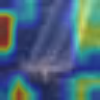

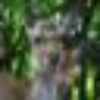

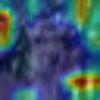

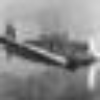

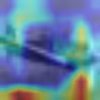

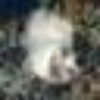

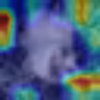

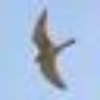

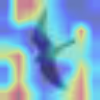

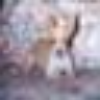

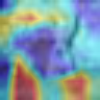

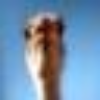

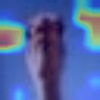

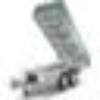

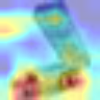

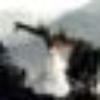

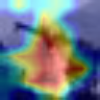

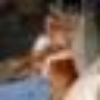

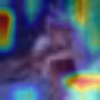

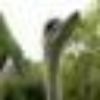

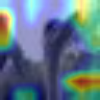

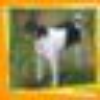

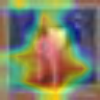

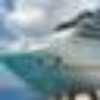

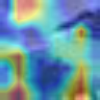

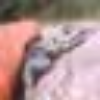

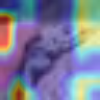

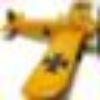

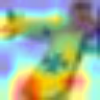

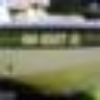

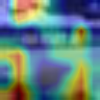

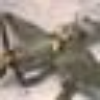

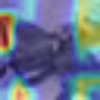

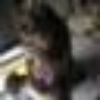

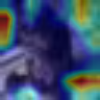

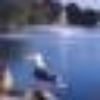

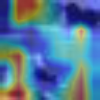

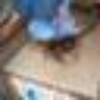

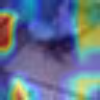

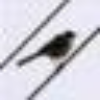

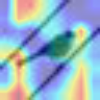

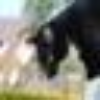

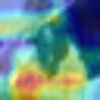

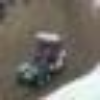

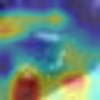

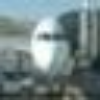

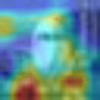

In [38]:
last_conv_layer = model.get_layer("dense_2_13_conv2D")
from keras_preprocessing import image
import keras.backend as K
from google.colab.patches import cv2_imshow
import cv2
for i, j, k in zip(class_output, index, [z for z in range(0, len(index))]):
    grads = K.gradients(i, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([[x_test[0]]])
    for i in range(12):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    img = j
    img_path = str(k) + '.jpg'
    image.utils.array_to_img(img).save(img_path)
    img = cv2.imread(img_path)
    img = cv2.resize(img,(100,100))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    cv2_imshow(img)
    cv2_imshow(superimposed_img)
    

In [39]:
!ls

0.jpg	15.jpg	20.jpg	26.jpg	31.jpg	37.jpg	42.jpg	48.jpg	8.jpg
10.jpg	16.jpg	21.jpg	27.jpg	32.jpg	38.jpg	43.jpg	49.jpg	9.jpg
11.jpg	17.jpg	22.jpg	28.jpg	33.jpg	39.jpg	44.jpg	4.jpg	model_plot.png
12.jpg	18.jpg	23.jpg	29.jpg	34.jpg	3.jpg	45.jpg	5.jpg	sample_data
13.jpg	19.jpg	24.jpg	2.jpg	35.jpg	40.jpg	46.jpg	6.jpg	weights.06.hdf5
14.jpg	1.jpg	25.jpg	30.jpg	36.jpg	41.jpg	47.jpg	7.jpg
